In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


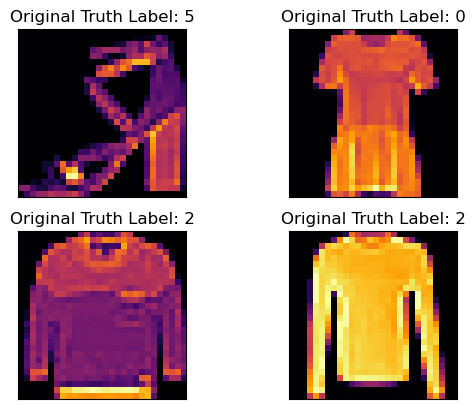

In [3]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Original Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Tranfer Learning

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Convolutional layer 1
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # Convolutional layer 2
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 1
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [6]:
# Initialize the model
model = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
# Training loop
epochs = 40
for epoch in range(epochs):
    running_loss = 0.0
    for data in trainLoader:
        images, _ = data
        images = images.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainLoader)
    train_losses.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainLoader)}")

print('Finished Training')


/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/40], Loss: 0.6409649311352387
Epoch [2/40], Loss: 0.5812645337856146
Epoch [3/40], Loss: 0.5774845825329519
Epoch [4/40], Loss: 0.5762061565669615
Epoch [5/40], Loss: 0.5755986958932775
Epoch [6/40], Loss: 0.5751670731156111
Epoch [7/40], Loss: 0.574909429560338
Epoch [8/40], Loss: 0.5746588070890797
Epoch [9/40], Loss: 0.5744332915175953
Epoch [10/40], Loss: 0.574254059778856
Epoch [11/40], Loss: 0.5741068122229342
Epoch [12/40], Loss: 0.5739519791816597
Epoch [13/40], Loss: 0.5738050192912251
Epoch [14/40], Loss: 0.5736485485837404
Epoch [15/40], Loss: 0.5735347422201242
Epoch [16/40], Loss: 0.5734529495239258
Epoch [17/40], Loss: 0.5733929872512817
Epoch [18/40], Loss: 0.5733247560732908
Epoch [19/40], Loss: 0.5733243687066443
Epoch [20/40], Loss: 0.5732800025802686
Epoch [21/40], Loss: 0.573251247914361
Epoch [22/40], Loss: 0.5732278356801218
Epoch [23/40], Loss: 0.5732227846948322
Epoch [24/40], Loss: 0.5732125095975424
Epoch [25/40], Loss: 0.5731833865012187
Epoch [26/40

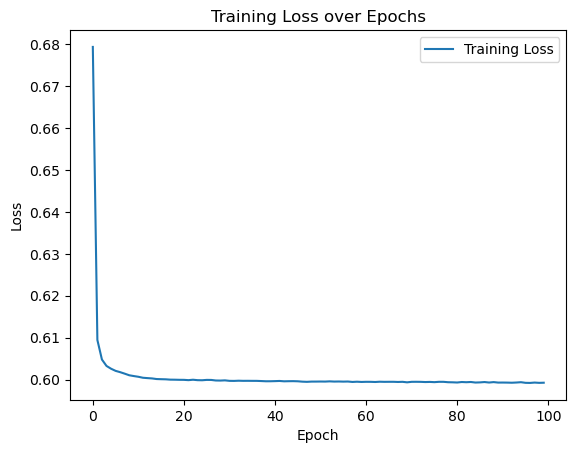

In [53]:
# Plot the training loss over epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


Original images


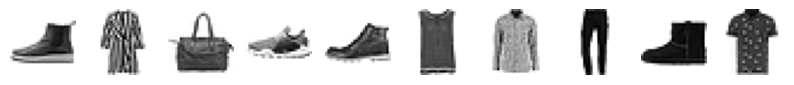

Reconstructed images


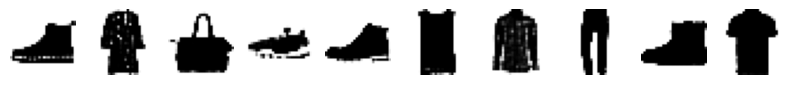

In [7]:
# Get a batch of test images
dataiter = iter(testLoader)
images, labels = next(dataiter)

# Show original images
plt.figure(figsize=(10, 4))
print('Original images')
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()

# Show reconstructed images
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    outputs = outputs.cpu()
    plt.figure(figsize=(10, 4))
    print('Reconstructed images')
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(outputs[i].numpy().squeeze(), cmap='gray_r')
        plt.axis('off')
    plt.show()



In [7]:
from sklearn.mixture import GaussianMixture

# Get latent space representations for training data
latent_vectors = []
with torch.no_grad():
    for data in trainLoader:
        images, _ = data
        images = images.to(device)
        latent_vector = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_vectors.append(latent_vector)
latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model
n_components = 2  # Adjust the number of components as needed
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(latent_vectors)


GaussianMixture(n_components=2)

/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


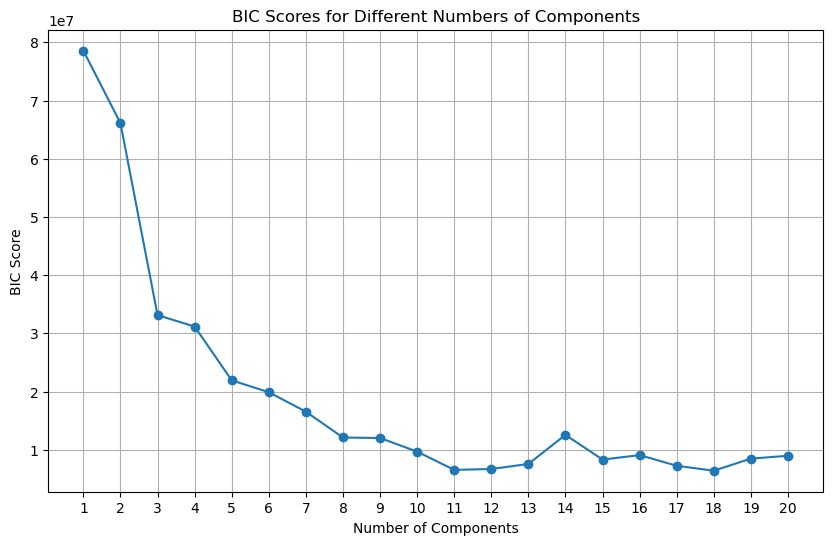

Optimal number of components: 18


In [56]:
# Initialize list to store BIC scores
bic_scores = []
num_components_range = range(2, 21)
# Try different numbers of components
for n_components in num_components_range:  # Adjust the range as needed
    # Fit GMM with current number of components
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(latent_vectors)  # Assuming latent_vectors is already computed
    
    # Calculate BIC score
    bic = gmm.bic(latent_vectors)
    bic_scores.append(bic)

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(num_components_range, bic_scores, marker='o', linestyle='-')
plt.title('BIC Scores for Different Numbers of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.xticks(num_components_range)
plt.grid(True)
plt.show()

# Find the optimal number of components with minimum BIC score
optimal_components = np.argmin(bic_scores) + 1  # +1 to account for 0-based indexing
print("Optimal number of components:", optimal_components)


In [8]:
# Get a sample input image
sample_input, _ = next(iter(trainLoader))
sample_input = sample_input.to(device)

# Pass the sample input through the encoder
with torch.no_grad():
    encoder_output = model.encoder(sample_input)

# Print the shape of the encoder output
print("Encoder output shape:", encoder_output.shape)
chanels = encoder_output.shape[1]
hight, wight = encoder_output.shape[2],encoder_output.shape[3]
hight

Encoder output shape: torch.Size([64, 8, 7, 7])


7

Generated images


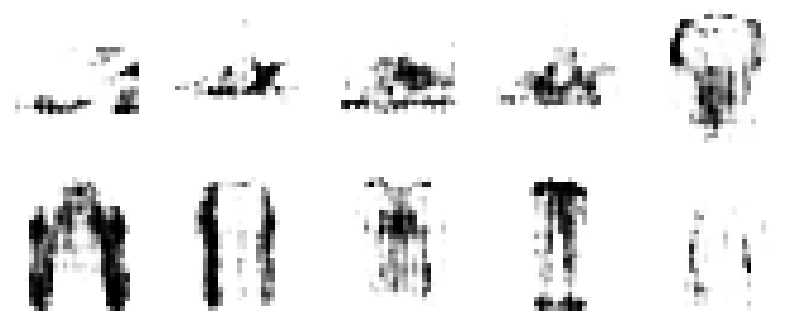

In [9]:
# Sample from the GMM
latent_samples = gmm.sample(10)  # Generate 10 samples
latent_samples = latent_samples[0]  # Extract samples

# Convert samples to torch tensor
latent_samples = torch.from_numpy(latent_samples).float().to(device)

# Generate images from sampled latent vectors
with torch.no_grad():
    generated_images = model.decoder(latent_samples.view(-1, chanels, hight, wight))  
    generated_images = generated_images.cpu()


# Visualize generated images
plt.figure(figsize=(10, 4))
print('Generated images')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()


/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generated images


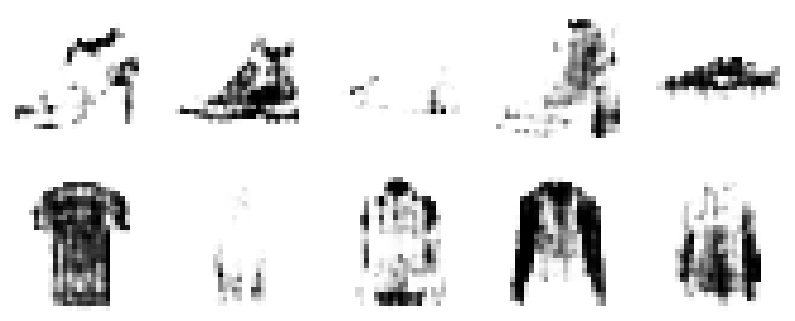

In [10]:
# Get latent space representations for training data
latent_vectors = []
with torch.no_grad():
    for data in trainLoader:
        images, _ = data
        images = images.to(device)
        latent_vector = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_vectors.append(latent_vector)
latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model
n_components = 11  # Adjust the number of components as needed
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(latent_vectors)

# Sample from the GMM
latent_samples = gmm.sample(10)  # Generate 10 samples
latent_samples = latent_samples[0]  # Extract samples

# Convert samples to torch tensor
latent_samples = torch.from_numpy(latent_samples).float().to(device)

# Generate images from sampled latent vectors
with torch.no_grad():
    generated_images = model.decoder(latent_samples.view(-1, chanels, hight, wight))  
    generated_images = generated_images.cpu()


# Visualize generated images
plt.figure(figsize=(10, 4))
print('Generated images')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()

Generated images


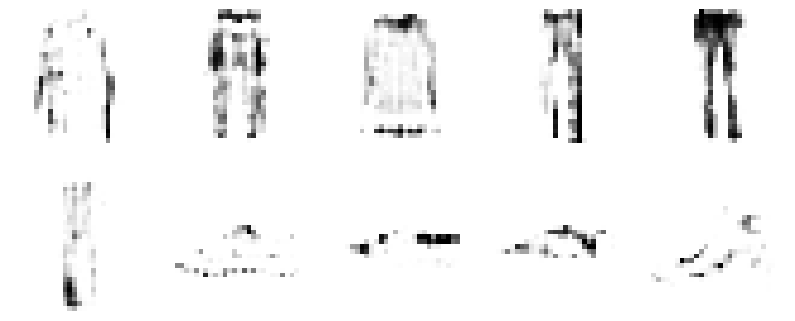

In [11]:
# Get latent space representations for training data
latent_vectors = []
with torch.no_grad():
    for data in trainLoader:
        images, _ = data
        images = images.to(device)
        latent_vector = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_vectors.append(latent_vector)
latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model
n_components = 18  # Adjust the number of components as needed
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(latent_vectors)



Generated images


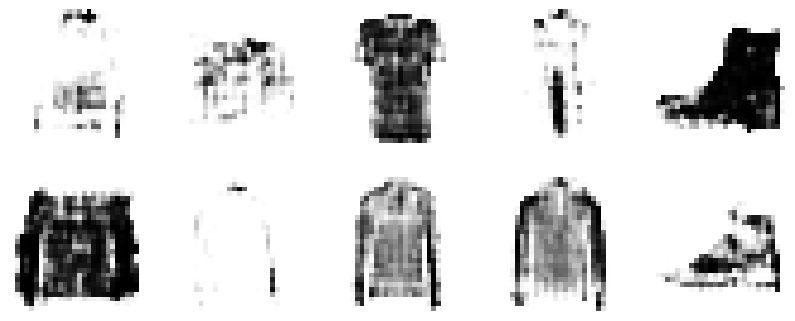

In [18]:
# Sample from the GMM
latent_samples = gmm.sample(10)  # Generate 10 samples
latent_samples = latent_samples[0]  # Extract samples

# Convert samples to torch tensor
latent_samples = torch.from_numpy(latent_samples).float().to(device)

# Generate images from sampled latent vectors
with torch.no_grad():
    generated_images = model.decoder(latent_samples.view(-1, chanels, hight, wight))  
    generated_images = generated_images.cpu()


# Visualize generated images
plt.figure(figsize=(10, 4))
print('Generated images')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()